# CTA simulation tools

## Introduction

In this tutorial we will simulate the expected counts of a Fermi/LAT source in the CTA energy range.

We will go through the following topics: 
 - handling of Fermi/LAT 3FHL catalogue with [gammapy.catalog.SourceCatalog3FHL](http://docs.gammapy.org/en/latest/catalog/)
 - handling of EBL tables with [gammapy.spectrum.TableModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.TableModel.html#gammapy.spectrum.models.TableModel)
 - handling of CTA responses with [gammapy.scripts.CTAPerf](http://docs.gammapy.org/en/latest/api/gammapy.scripts.CTAPerf.html?highlight=ctaperf)
 - simulation of an observation for a given set of parameters with [gammapy.scripts.CTAObservationSimulation](http://docs.gammapy.org/en/latest/api/gammapy.scripts.CTAObservationSimulation.html#gammapy.scripts.CTAObservationSimulation)
 - Illustration of Sherpa power to fit an observation with a user model (coming soon)
 
## Setup

In order to deal with plots we will begin with matplotlib import:  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Suppress some irrelevant warnings in this notebook
# that occur from matplotlib plotting and table printing
import warnings; warnings.filterwarnings('ignore')

## PKS 2155-304 selection from the 3FHL Fermi/LAT catalogue
We will start by selecting the source PKS 2155-304 in the 3FHL Fermi/LAT catalogue for further use.

In [3]:
from gammapy.catalog import SourceCatalog3FHL

# load catalogs
fermi_3fhl = SourceCatalog3FHL()
name = 'PKS 2155-304'
source = fermi_3fhl[name]

We can then access the caracteristics of the source via the `data` attribut and select its spectral model for further use. 

In [4]:
redshift = source.data['Redshift']
spectral_model = source.spectral_model

Here is an example on how to plot the source spectra

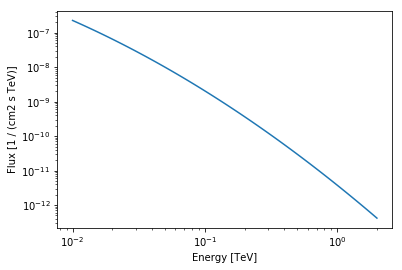

In [5]:
# plot the Fermi/LAT model
import astropy.units as u
spectral_model.plot(energy_range=[10 * u.GeV, 2 *u.TeV])

## Select a model for EBL absorption
We will need to modelise EBL (extragalactic background light) attenuation to have get a 'realistic' simulation. Different models are available in GammaPy. Here is an example on how to deal with the absorption coefficients. 

In [6]:
from gammapy.spectrum.models import TableModel

# Load models for PKS 2155-304 redshift 
franceschini = TableModel.read_xspec_model('$GAMMAPY_EXTRA/datasets/ebl/ebl_franceschini.fits.gz', param=redshift)
dominguez = TableModel.read_xspec_model('$GAMMAPY_EXTRA/datasets/ebl/ebl_dominguez11.fits.gz', param=redshift)
finke = TableModel.read_xspec_model('$GAMMAPY_EXTRA/datasets/ebl/frd_abs.fits.gz', param=redshift)

From here you can have access to the absorption coefficient for a given energy.

In [7]:
energy = 1 * u.TeV
abs_value = dominguez.evaluate(energy=energy, amplitude=1.)
print('absorption({} {}) = {}'.format(energy.value, energy.unit, abs_value))

absorption(1.0 TeV) = 0.2739958046262352


Below is an example to plot EBL absorption for different models 

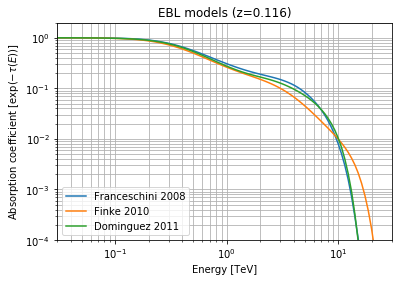

In [8]:
# define energy range for the plot
energy_range = [0.03, 30] * u.TeV

# start customised plot
ax = plt.gca()
opts = dict(energy_range=energy_range, energy_unit='TeV', ax=ax)
franceschini.plot(label='Franceschini 2008', **opts)
finke.plot(label='Finke 2010', **opts)
dominguez.plot(label='Dominguez 2011', **opts)

# tune plot
ax.set_ylabel(r'Absorption coefficient [$\exp{(-\tau(E))}$]')
ax.set_xlim(energy_range.value)  # we get ride of units
ax.set_ylim([1.e-4, 2.])
ax.set_yscale('log')
ax.set_title('EBL models (z=' + str(redshift) + ')')
plt.grid(which='both')
plt.legend(loc='best') # legend

# show plot
plt.show()

## CTA instrument response functions
Here we are going to deal with CTA point-like instrument response functions (public version, production 2). Data format for point-like IRF is still missing. For now, a lot of efforts is made to define full-containment IRFs (https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/index.html). In the meantime a temporary format is used in gammapy. It will evolved.

To simulate one observation we need the following IRFs: 
 - effective area as a function of true energy (energy-dependent theta square cute)
 - background rate as a function of reconstructed energy (energy-dependent theta square cute)
 - migration matrix, e_reco/e_true as a function of true energy
 
To handle CTA's responses we will use the `CTAPerf` class

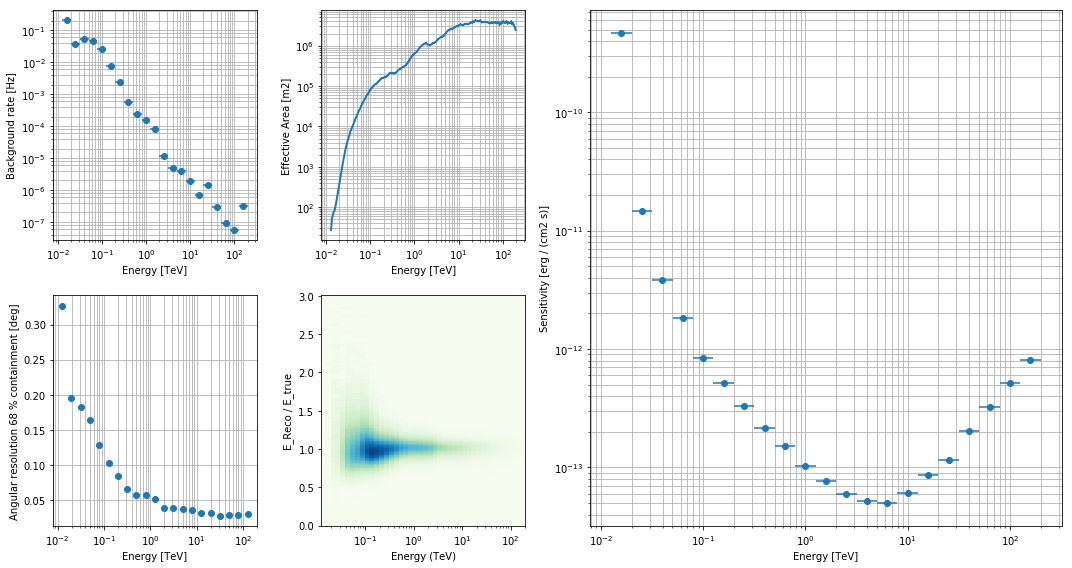

In [9]:
from gammapy.scripts import CTAPerf
# South array optimisation for faint source 
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/South_50h.fits.gz'
cta_perf = CTAPerf.read(filename)
cta_perf.peek()

Different optimisations are available for different type of source (bright, 0.5h; medium, 5h; faint, 50h). Here is an example to have a quick look to the different optimisation

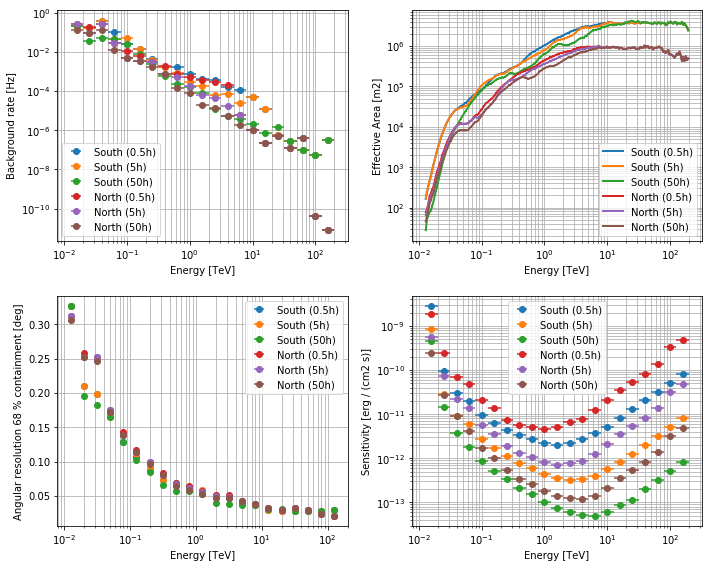

In [10]:
prod_dir = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/'
opti = ['0.5h', '5h', '50h']
site = ['South', 'North']
cta_perf_list = []  # will be filled with different performance
labels = []  # will be filled with different performance labels for the legend
for isite in site: 
    for iopti in opti:
        filename = prod_dir + '/' + isite + '_' + iopti + '.fits.gz'
        cta_perf = CTAPerf.read(filename)
        cta_perf_list.append(cta_perf)
        labels.append(isite + ' (' + iopti + ')')

CTAPerf.superpose_perf(cta_perf_list, labels)

## CTA simulation of an observation
Now we are going to simulate the expected counts in the CTA energy range. To do so we will need to specify a target (caracteristics of the source) and the parameters of the observation (such as time, ON/OFF normalisation, etc.)

### Target definition

In [11]:
from gammapy.scripts.cta_utils import Target
target = Target(
    name=source.data['Source_Name'],  # from the 3FGL catalogue source class
    model=source.spectral_model,  # defined above
    redshift=redshift,  # defined above
    ebl_model_name='franceschini',
)

In [12]:
print(target)

*** Target parameters ***
Name=3FHL J2158.8-3013 
amplitude=7.707001703494143e-11 1 / (cm2 GeV s)
reference=18.31732177734375 GeV
alpha=1.8807274103164673 
beta=0.14969758689403534 
Redshift=0.11599999666213989


### Observation definition

In [13]:
from gammapy.scripts.cta_utils import ObservationParameters
alpha = 0.2 * u.Unit('')  # normalisation between ON and OFF regions
livetime = 5. * u.h
# energy range used for statistics (excess, significance, etc.)
emin, emax = 0.05 * u.TeV, 5 * u.TeV
params = ObservationParameters(
    alpha=alpha, livetime=livetime,
    emin=emin, emax=emax,
)

In [14]:
print(params)

*** Observation parameters summary ***
alpha=0.2 []
livetime=5.0 [h]
emin=0.05 [TeV]
emax=5.0 [TeV]



### Performance

In [15]:
from gammapy.scripts import CTAPerf
# PKS 2155-304 is 10 % of Crab at 1 TeV ==> intermediate source
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/South_5h.fits.gz'
perf = CTAPerf.read(filename)

### Simulation

Here we are going to simulate what we expect to see with CTA and measure the duration of the simulation

In [16]:
import time  # to estimate duration of a process
from gammapy.scripts.cta_utils import CTAObservationSimulation

t_start = time.clock()  # start timing
simu = CTAObservationSimulation.simulate_obs(
    perf=perf, target=target, obs_param=params)
t_end = time.clock()

# print simulation results
print(simu)

# print time needed to run the simulation (0.015 s on my personal laptop)
print('\nsimu done in {} s'.format(t_end-t_start))

*** Observation summary report ***
Observation Id: 0
Livetime: 5.000 h
On events: 8469
Off events: 10412
Alpha: 0.200
Bkg events in On region: 2082.40
Excess: 6386.60
Excess / Background: 3.07
Gamma rate: 2.13 1 / min
Bkg rate: 0.69 1 / min
Sigma: 90.39
energy range: 0.05 TeV - 5.01 TeV

simu done in 0.023168000000001854 s


Now we can take a look at the excess, ON and OFF distributions

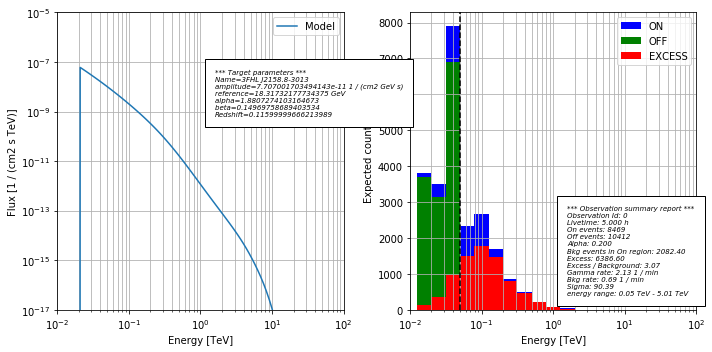

In [17]:
CTAObservationSimulation.plot_simu(simu, target)

We can access simulation parameters via the [gammapy.spectrum.SpectrumStats](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumStats.html#gammapy.spectrum.SpectrumStats) attribute of the [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html#gammapy.spectrum.SpectrumObservation) class:

In [18]:
stats = simu.total_stats_safe_range
stats_dict = stats.to_dict()
print('excess: {}'.format(stats_dict['excess']))
print('sigma: {:.1f}'.format(stats_dict['sigma']))

excess: 6386.6
sigma: 90.4


Finally, you can get statistics for every reconstructed energy bin with: 

In [19]:
table = simu.stats_table()
# Here we only print part of the data from the table
table[['energy_min', 'energy_max', 'excess', 'background', 'sigma']][:10]

energy_min,energy_max,excess,background,sigma
TeV,TeV,,,
float64,float64,float64,float64,float64
0.012589254416525364,0.019952623173594475,135.4,3688.6,2.02084455075
0.019952623173594475,0.03162277862429619,375.4,3142.6,5.97768008628
0.03162277862429619,0.05011872574687004,987.4,6903.6,10.5632784031
0.05011872574687004,0.07943282276391983,1503.0,846.0,37.2165221954
0.07943282276391983,0.1258925497531891,1786.4,886.6,42.2455267642
0.1258925497531891,0.19952623546123505,1471.6,232.4,51.5754928155
0.19952623546123505,0.3162277638912201,802.6,68.4,42.4619014762
0.3162277638912201,0.5011872053146362,473.8,26.2,34.5678682548


## Excercises
 - do the same thing for the source 1ES 2322-40.9 (faint BL Lac object)
 - repeat the procedure 10 times and average detection results (excess and significance)
 - estimate the time needed to have a 5-sigma detection for Cen A (core)